In [ ]:
 ### Prepare module structure ###

import sys
sys.path.append("../")

In [ ]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
from data import *
import models

import pickle

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

In [ ]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print('using device:', device)

In [ ]:
### LOAD DATA ###
dataset = 'mnist'
dataloader, imsize = load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=32)

sample = next(iter(dataloader['train']))
plot_grid(sample)
print(sample.shape)
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft**2, -1))

In [ ]:
def calc_meas(x):
    m = A.shape[1]
    n = x.shape[-1] * x.shape[-2]
    assert(m <= n)
    N = x.shape[0]
    C = x.shape[1]
    compressed = (x.view(N, C, -1) @ A).view(N, C, m)
    compressed = torch.abs(compressed)

    compr_pad = nn.functional.pad(compressed, (0, n - m), mode='constant', value=0).reshape(x.shape)
    
    return compressed, compr_pad

# Function to compute test images

def test_generator(model, device, testloader):
    # put model to eval mode
    model = model.to(device=device)
    model.eval()

    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    outputs = []
    
    for data in testloader:
        z = torch.randn(*data.shape).to(device)
        data = data.to(device=device)
        _, meas_pad = calc_meas(data)
        ouput = model(meas_pad)

        test_images.append(data.cpu().numpy())
        outputs.append(ouput.cpu().detach().numpy())
    
    return np.concatenate(test_images), np.concatenate(outputs)

In [ ]:
# Define loss

def gen_loss(gen_output, x):
    return  torch.mean(torch.abs(gen_output - x))

In [ ]:
m = 25 # 10, 25, 50, 100, 200, 300, 500, 784

import pickle

#A = (torch.randn(imsize[1] * imsize[2], m) / m).to(device)
#pickle.dump(A, open("../cache/A/A{}.p".format(m), "wb"))

A = pickle.load(open("../cache/A/A{}.p".format(m), "rb")).to(device)

print(A.shape)

In [ ]:
### Create new models ###

gen = models.FCNet(imsize=imsize, h=2048)

In [ ]:
# Set training parameters

opt = optim.Adam(gen.parameters(), lr=1e-3)

In [ ]:
# Initial loss

gen = gen.to(device)
sample = sample.to(device)
sample_magnitudes = sample_magnitudes.to(device)

gen_out = gen(sample_magnitudes)

loss = gen_loss(gen_out, sample)

print("Generator loss:", loss.item())

In [ ]:
# Train function (short)
def train_model(gen, opt, device, loader_train, epochs=1):
    gen = gen.to(device=device)
    
    history = []
    
    for e in range(epochs):
        for t, x in enumerate(loader_train):
            gen.train()
            
            x = x.to(device=device)
            _, meas_pad = calc_meas(x)
            
            loss = gen_loss(gen(meas_pad), x)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            history.append(loss.item())

            if t % 100 == 0:
                print("epoch: {:2} \t step:{} \t loss: {:3.4}".format(e+1, t, history[-1]))  

    return history

In [ ]:
### TRAIN MODEL ###

num_epochs = 1

train_model(gen, opt, device, dataloader['train'], epochs=num_epochs)

gen_weights = gen.state_dict().copy()

torch.save(gen_weights, "../cache/e2e/Ameas{1}FCNet2048MNIST_{0:04d}.sd".format(num_epochs, m))

In [ ]:
### TRAIN MODEL - BIG LOOP ###

num_epochs = 100

for m in [10, 25, 50, 100, 200, 300, 500, 784]:

    A = pickle.load(open("../cache/A/A{}.p".format(m), "rb")).to(device)

    gen = models.FCNet(imsize=imsize, h=2048)
    
    opt = optim.Adam(gen.parameters(), lr=1e-3)

    train_model(gen, opt, device, dataloader['train'], epochs=num_epochs)

    gen_weights = gen.state_dict().copy()

    torch.save(gen_weights, "../cache/e2e/Ameas{1}FCNet2048MNIST_{0:04d}.sd".format(num_epochs, m))

Version 0.4
epoch:  1 	 step:0 	 loss: 0.4723
epoch:  1 	 step:100 	 loss: 0.1102
epoch:  1 	 step:200 	 loss: 0.1256
epoch:  1 	 step:300 	 loss: 0.1112
epoch:  1 	 step:400 	 loss: 0.1107
epoch:  1 	 step:500 	 loss: 0.1084
epoch:  1 	 step:600 	 loss: 0.1075


In [79]:
### LOAD MODEL ####

m = 784
num_epochs = 100

A = pickle.load(open("../cache/A/A{}.p".format(m), "rb")).to(device)
print(A.shape)

gen = models.FCNet(imsize=imsize, h=2048)

# TODO: map storage location to correct GPU!
gen.load_state_dict(torch.load("../cache/e2e/Ameas{1}FCNet2048MNIST_{0:04d}.sd".format(num_epochs, m), map_location={'cuda:1': device.__str__()}));
gen.eval();

torch.Size([784, 784])
Version 0.4


In [80]:
# Calculate test predictions #

test_images, test_outputs = test_generator(gen, device, dataloader['test'])
print(test_images.shape)

(8000, 1, 28, 28)


In [81]:
### CACHE RESULTS ###

import pickle
pickle.dump(test_images, open("/home/shared/phase-retrieval/test/FCnet_MNIST/Ameas{}_e2e_6_1024_original.p".format(m), "wb"))
pickle.dump(test_outputs, open("/home/shared/phase-retrieval/test/FCnet_MNIST/Ameas{}_e2e_6_1024.p".format(m), "wb"))

In [82]:
### LOAD RESULTS ###
import pickle

test_images = pickle.load(open("/home/shared/phase-retrieval/test/FCnet_MNIST/Ameas{}_e2e_6_1024_original.p".format(m), "rb"))
test_outputs = pickle.load(open("/home/shared/phase-retrieval/test/FCnet_MNIST/Ameas{}_e2e_6_1024.p".format(m), "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


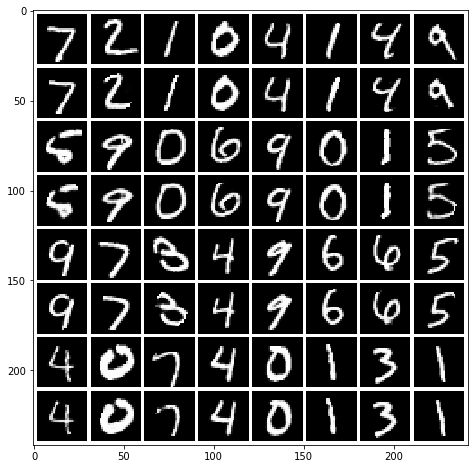

In [83]:
# Print test predictions 2 #

to_plot = np.stack([test_images[:32, 0].reshape(4, 8, 28, 28), 
                    test_outputs[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
                
plot_grid(to_plot, figsize=(8,8), file="../out/e2e/mnist/Ameas{}_6_1024.png".format(m))
#plot_grid(to_plot, figsize=(8,8))

#plot_grid(torch.Tensor(np.stack([test_images[:32, 0].reshape(4, 8, 28, 28), test_outputs[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)),
#          file='/home/shared/phase-retrieval/out/cgan/'+dataset+'/cgan{0}.pdf'.format(time.strftime("%Y%m%d_%H%M%S")))

In [84]:
# Benchmark test predictions #

benchmark(pred=test_outputs[:1024], true=test_images[:1024], check_all=True)

Signal error:
  MSE: 0.0065512887945260445, std: 0.005719570283165434
  MAE: 0.02003528630348228, std: 0.008949239868018929
  SSIM: 0.9432037738032379, std: 0.04179414587482828
  Sharpness: 0.05325729095071094, std: 0.019765983143833946
  PhCo-MSE: 0.0065722280533009325, std: 0.005796348888875825
  PhCo-MAE: 0.020069960328783054, std: 0.009053772254600148
  PhCo-SSIM: 0.9429748814521584, std: 0.04265781566745166
  CroCo-MSE: 0.0065512887945260445, std: 0.005719570283165434
  CroCo-MAE: 0.02003528630348228, std: 0.008949239868018929
  CroCo-SSIM: 0.9432037738032379, std: 0.04179414587482828

Magnitude error:
  MSE Magnitude: 2.2394212979050616, std: 1.9854580553499424

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.006551 | 0.02004 | 0.9432 | 0.05326 | 0.006572 | 0.02007 | 0.9430 | 0.006551 | 0.02004 | 0.9432 | 2.239 |


## Evaluation for different E2E models (1024 samples)


| Nr Type | epochs | m | MSE | MAE | SSIM | FASI-MSE | FASI-MAE | COCO-MSE | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 4 | 100 | 784 | 0.006551 | 0.02004 | 0.9432 | 0.05326 | 0.006572 | 0.02007 | 0.9430 | 0.006551 | 0.02004 | 0.9432 | 2.239 |
| 4 | 100 | 500 | 0.007027 | 0.02111 | 0.9380 | 0.05549 | 0.007027 | 0.02111 | 0.9380 | 0.007027 | 0.02111 | 0.9380 | 2.392 |
| 4 | 100 | 300 | 0.007873 | 0.02317 | 0.9294 | 0.05961 | 0.007887 | 0.02320 | 0.9293 | 0.007873 | 0.02317 | 0.9294 | 2.651 |
| 4 | 100 | 200 | 0.009301 | 0.02555 | 0.9159 | 0.06465 | 0.009533 | 0.02582 | 0.9144 | 0.009265 | 0.02552 | 0.9162 | 3.141 |
| 4 | 100 | 100 | 0.01216 | 0.03078 | 0.8869 | 0.07385 | 0.01241 | 0.03109 | 0.8849 | 0.01214 | 0.03076 | 0.8870 | 3.996 |
| 4 | 100 | 50 | 0.02070 | 0.04415 | 0.8090 | 0.09379 | 0.02330 | 0.04703 | 0.7941 | 0.02049 | 0.04392 | 0.8105 | 6.666 |
| 4 | 100 | 25 | 0.03804 | 0.06606 | 0.6791 | 0.1195 | 0.04527 | 0.07384 | 0.6506 | 0.03608 | 0.06389 | 0.6925 | 11.41 |
| 4 | 100 | 10 | 0.07744 | 0.1072 | 0.4541 | 0.1493 | 0.08662 | 0.1167 | 0.4427 | 0.06661 | 0.09577 | 0.5147 | 21.46 |